In [67]:
#Some useful dependencies:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random as rnd

import missingno
import folium

from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tbilisi-housing-challenge-2020/housing_clean_2.csv
/kaggle/input/tbilisi-housing-challenge-2020/house_3.json
/kaggle/input/tbilisi-housing-challenge-2020/housing_clean_1.csv


# Loading the file and initial EDA + DP:

In [68]:
df = pd.read_csv('/kaggle/input/tbilisi-housing-challenge-2020/housing_clean_2.csv')
df.head()

,Unnamed: 0,price,space,room,bedroom,furniture,latitude,longitude,city_area,floor,max_floor,apartment_type,renovation_type,balcony
0,0,107100,28.0,1,1,0,41.724521,44.753788,Saburtalo District,11,11,new,newly renovated,1
1,2,257000,72.0,3,1,1,41.689502,44.820050,Isani District,15,16,new,newly renovated,0
2,3,157200,53.0,2,1,0,41.677084,44.817222,Krtsanisi District,2,4,new,white frame,1
3,4,237200,80.0,3,2,0,41.682883,44.823815,Krtsanisi District,3,4,new,white frame,1
4,5,158200,60.0,2,1,0,41.768762,44.724123,Saburtalo District,14,16,old,newly renovated,0


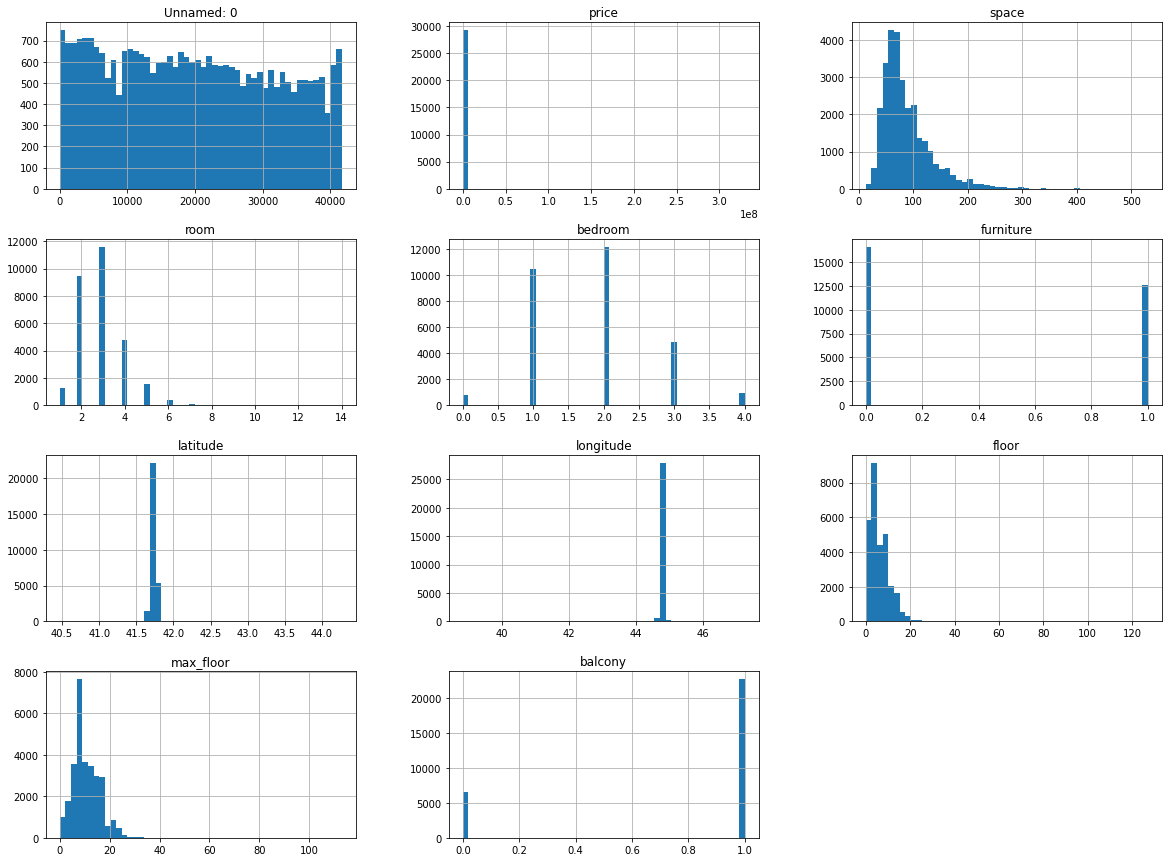

In [69]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Here are some insights:

- price seems to be affected by some ridiculous outlier (3e8)
- same with coordinates (longitude, latitude) -> to be fixed by trimming

In [70]:
cols = ['longitude', 'latitude', 'price']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

Also, floor and max_floor are heavily skewed/feature some significant outliers, so let's filter the dataset:

In [71]:
df = df[(df['floor'] <= 30 ) & (df['max_floor'] <= 30)]

In [72]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,22670.0,19822.725981,12045.382208,0.000000,9506.250000,19331.500000,29872.750000,41662.000000
price,22670.0,254612.518747,126906.192866,3300.000000,158200.000000,224100.000000,326175.000000,624800.000000
space,22670.0,82.892054,36.210745,13.000000,57.000000,75.000000,100.000000,350.000000
room,22670.0,2.837803,0.956936,1.000000,2.000000,3.000000,3.000000,14.000000
bedroom,22670.0,1.758800,0.802229,0.000000,1.000000,2.000000,2.000000,4.000000
furniture,22670.0,0.438994,0.496275,0.000000,0.000000,0.000000,1.000000,1.000000
latitude,22446.0,41.719659,0.020675,41.669374,41.707897,41.722811,41.730687,41.773244
longitude,22446.0,44.781695,0.042355,44.679009,44.753788,44.773299,44.805342,44.895674
floor,22670.0,6.164446,4.185501,0.000000,3.000000,5.000000,9.000000,26.000000
max_floor,22670.0,10.615659,5.155726,0.000000,7.000000,10.000000,14.000000,30.000000


Unnamed 0 is unnecessary - I'll drop it:

In [73]:
df = df.drop(labels='Unnamed: 0', axis=1)

In [74]:
df.head()

,price,space,room,bedroom,furniture,latitude,longitude,city_area,floor,max_floor,apartment_type,renovation_type,balcony
0,107100,28.0,1,1,0,41.724521,44.753788,Saburtalo District,11,11,new,newly renovated,1
1,257000,72.0,3,1,1,41.689502,44.820050,Isani District,15,16,new,newly renovated,0
2,157200,53.0,2,1,0,41.677084,44.817222,Krtsanisi District,2,4,new,white frame,1
3,237200,80.0,3,2,0,41.682883,44.823815,Krtsanisi District,3,4,new,white frame,1
4,158200,60.0,2,1,0,41.768762,44.724123,Saburtalo District,14,16,old,newly renovated,0


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22670 entries, 0 to 29203
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            22670 non-null  int64  
 1   space            22670 non-null  float64
 2   room             22670 non-null  int64  
 3   bedroom          22670 non-null  int64  
 4   furniture        22670 non-null  int64  
 5   latitude         22446 non-null  float64
 6   longitude        22446 non-null  float64
 7   city_area        22670 non-null  object 
 8   floor            22670 non-null  int64  
 9   max_floor        22670 non-null  int64  
 10  apartment_type   22664 non-null  object 
 11  renovation_type  22670 non-null  object 
 12  balcony          22670 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 2.4+ MB


An interestin package is missingno - you can get a quick glimpse of any NaNs present:

<AxesSubplot:>

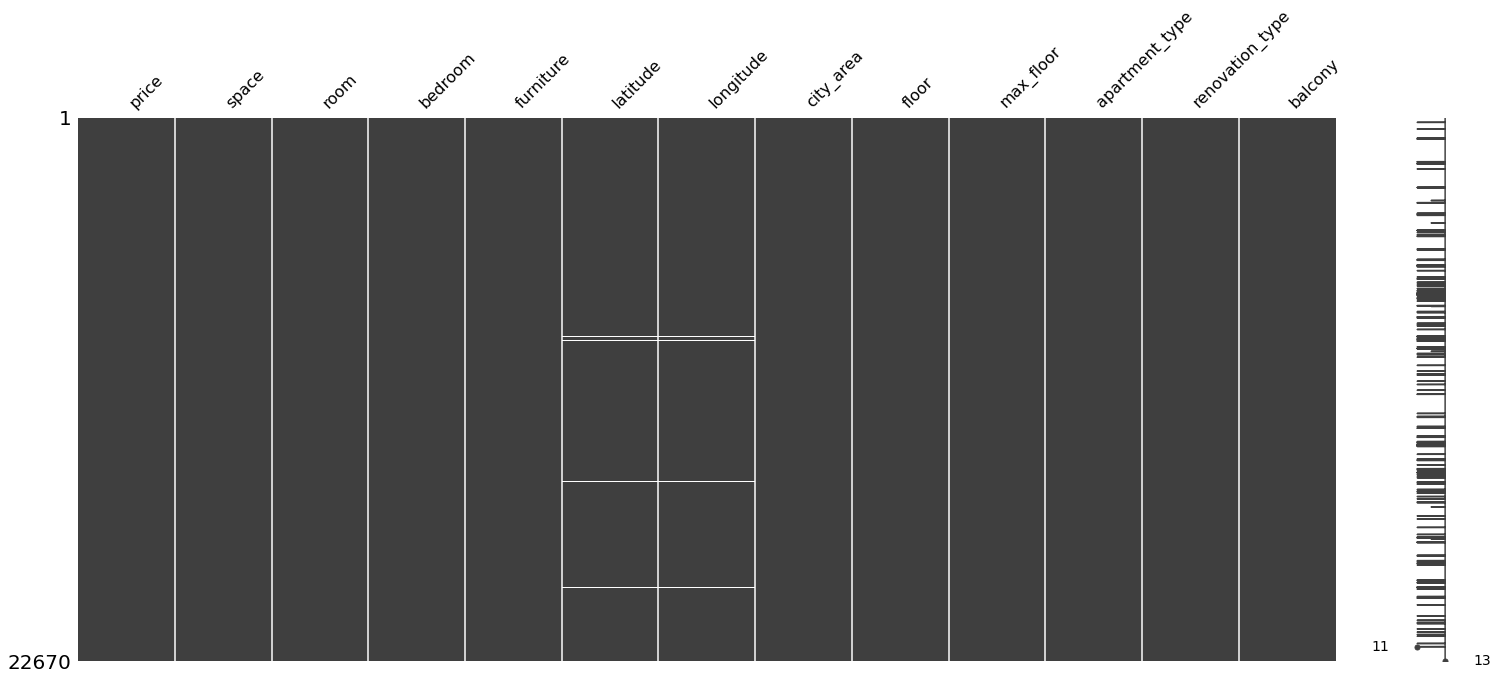

In [76]:
missingno.matrix(df)

Looking at both the info method and the missingno matrix, we can see that the NaNs can just be deleted, because there are not that many to affect the dataset greatly

In [77]:
df = df.dropna(subset = ['latitude', 'longitude', 'apartment_type'])

<AxesSubplot:>

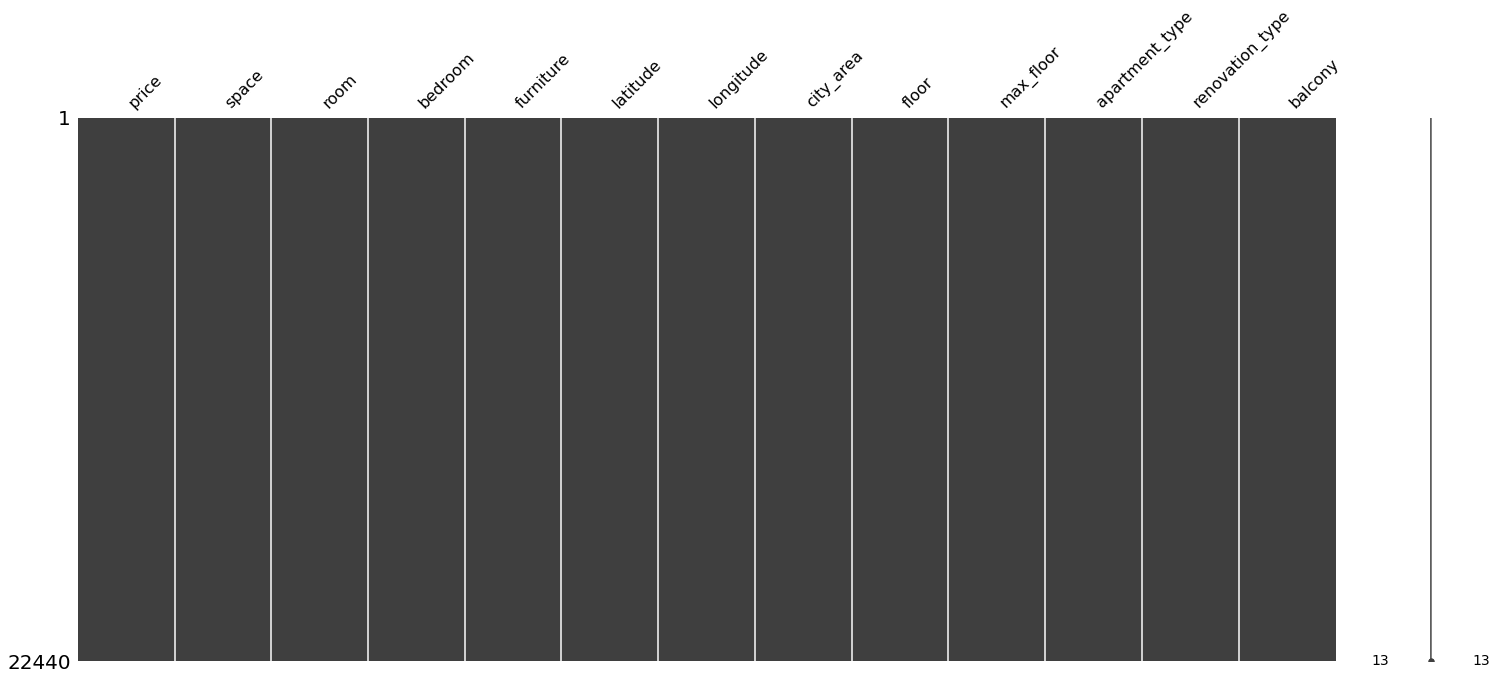

In [78]:
missingno.matrix(df)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22440 entries, 0 to 29203
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            22440 non-null  int64  
 1   space            22440 non-null  float64
 2   room             22440 non-null  int64  
 3   bedroom          22440 non-null  int64  
 4   furniture        22440 non-null  int64  
 5   latitude         22440 non-null  float64
 6   longitude        22440 non-null  float64
 7   city_area        22440 non-null  object 
 8   floor            22440 non-null  int64  
 9   max_floor        22440 non-null  int64  
 10  apartment_type   22440 non-null  object 
 11  renovation_type  22440 non-null  object 
 12  balcony          22440 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 2.4+ MB


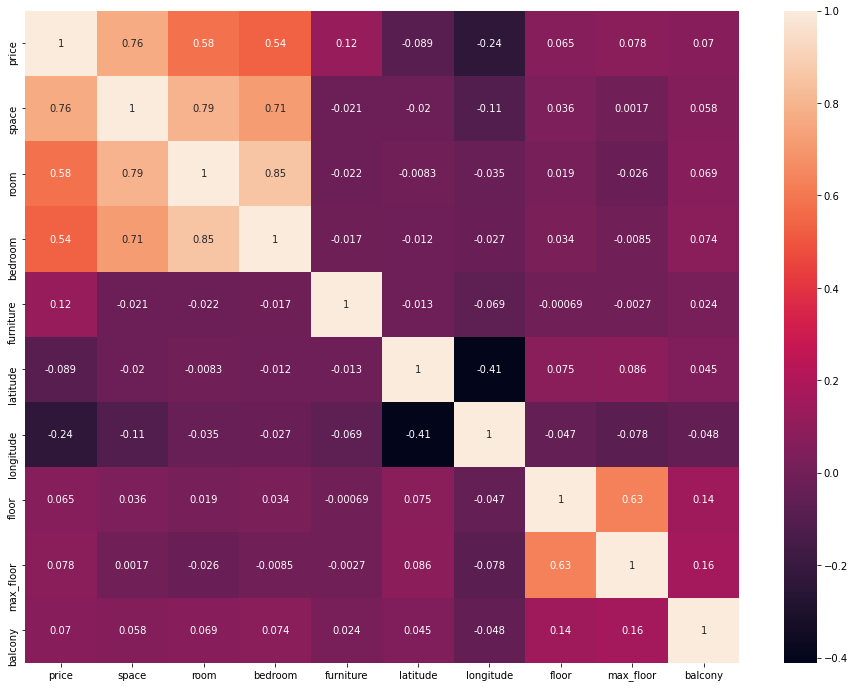

In [80]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), annot=True)
plt.show()

There are some relationships to visualize:

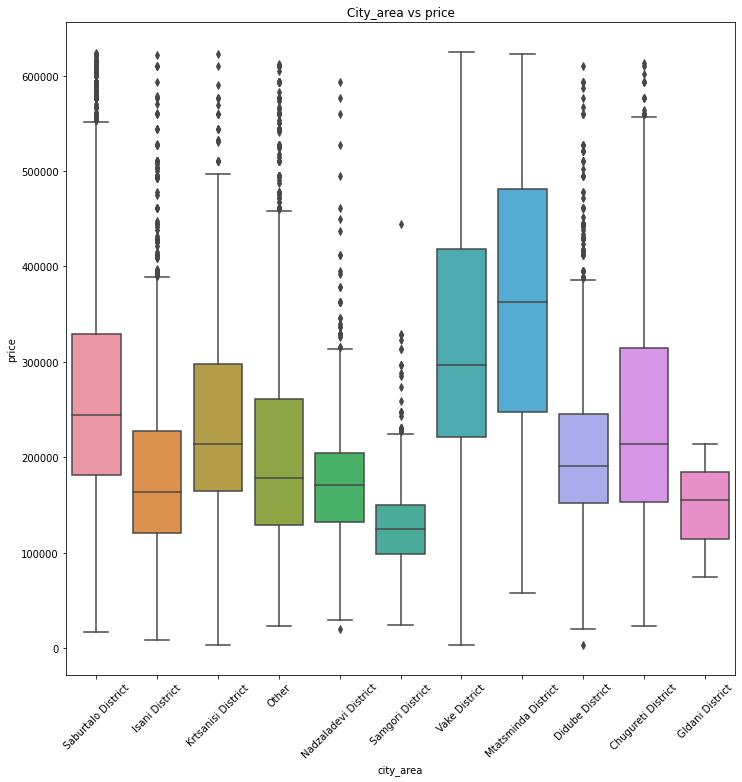

In [81]:
plt.figure(figsize=(12,12))
plt.title('City_area vs price')
sns.boxplot(x=df['city_area'], y=df['price'])
plt.xticks(rotation = 45)
plt.show()

Mtatsminda and Vake districts seem to be the most expensive districts - I can confirm that ;) They do look very nice compared to other districts.

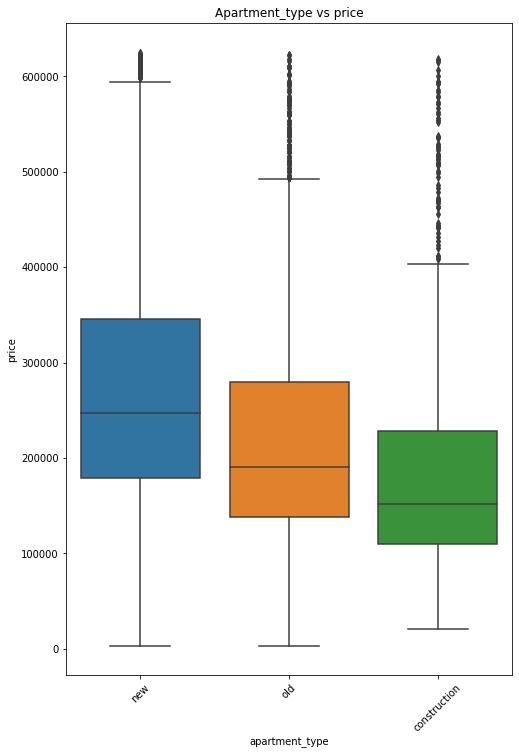

In [82]:
plt.figure(figsize=(8,12))
plt.title('Apartment_type vs price')
sns.boxplot(x=df['apartment_type'], y=df['price'])
plt.xticks(rotation = 45)
plt.show()

New apartments tend to be more expensive than older ones, indeed ;)

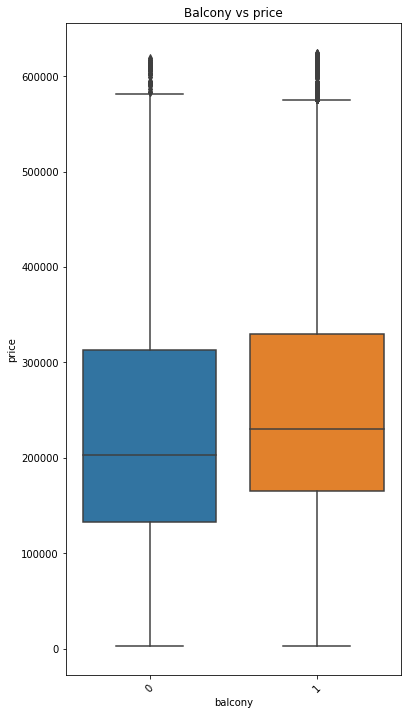

In [83]:
plt.figure(figsize=(6,12))
plt.title('Balcony vs price')
sns.boxplot(x=df['balcony'], y=df['price'])
plt.xticks(rotation = 45)
plt.show()

A slight difference can be observed, if you have a balcony.

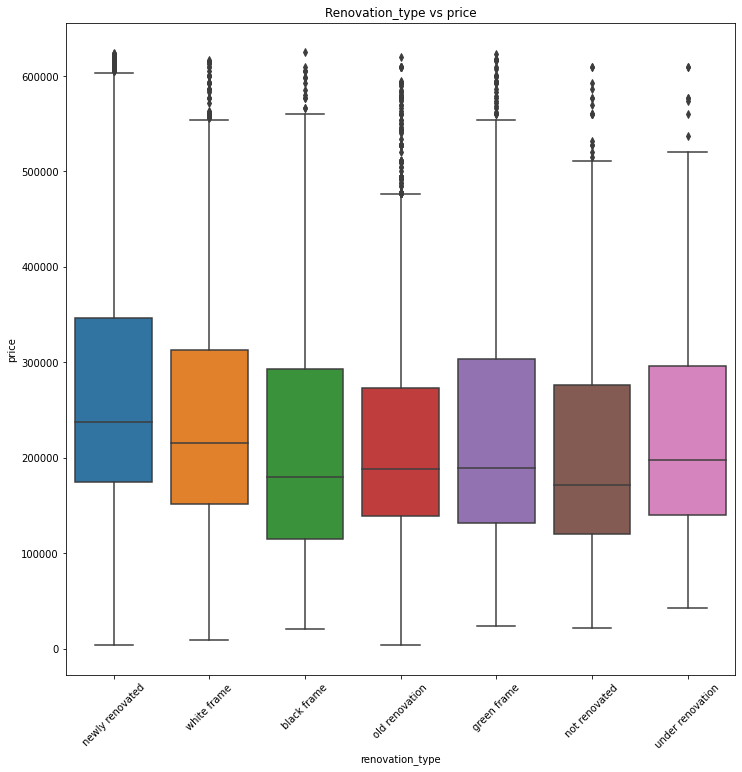

In [84]:
plt.figure(figsize=(12,12))
plt.title('Renovation_type vs price')
sns.boxplot(x=df['renovation_type'], y=df['price'])
plt.xticks(rotation = 45)
plt.show()

Newly renovated are of course the most expensive and not renovated are the least expensive (judging by the median), but overall the relationship is rather underwhelming.

# Visualizing the map:

I'll try to make a cute little visualization of Tbilisi with dots colored by districts - we'll use the folium library. Here are the coords of Tbilisi pulled from google maps:

In [85]:
TBI_COORDS = [41.7151, 44.8271]

Ok, let's generate a map:

In [86]:
map_tbi = folium.Map(location=TBI_COORDS, zoom_start=12, 
tiles='cartodbpositron', width=640, height=480)

We will use the initial dataframe and fix the index after all the initial preprocessing:

In [87]:
df = df.reset_index(drop=True)

In [88]:
df.head(10)

,price,space,room,bedroom,furniture,latitude,longitude,city_area,floor,max_floor,apartment_type,renovation_type,balcony
0,107100,28.0,1,1,0,41.724521,44.753788,Saburtalo District,11,11,new,newly renovated,1
1,257000,72.0,3,1,1,41.689502,44.820050,Isani District,15,16,new,newly renovated,0
2,157200,53.0,2,1,0,41.677084,44.817222,Krtsanisi District,2,4,new,white frame,1
3,237200,80.0,3,2,0,41.682883,44.823815,Krtsanisi District,3,4,new,white frame,1
4,158200,60.0,2,1,0,41.768762,44.724123,Saburtalo District,14,16,old,newly renovated,0
5,184500,74.0,2,1,0,41.682883,44.823815,Krtsanisi District,7,12,new,white frame,1
6,150300,57.0,2,1,0,41.730734,44.743925,Saburtalo District,1,6,new,white frame,1
7,125200,50.0,2,1,0,41.724521,44.753788,Saburtalo District,3,12,new,white frame,1
8,230700,100.0,2,1,0,41.748504,44.841686,Other,5,12,construction,white frame,1
9,375600,90.0,3,2,1,41.725054,44.754502,Saburtalo District,2,15,new,newly renovated,0


In [89]:
districts = list(df['city_area'].unique())

print(f'There are {len(districts)} districts.')
print(f'List of the districts: {districts}')

There are 11 districts.
List of the districts: ['Saburtalo District', 'Isani District', 'Krtsanisi District', 'Other', 'Nadzaladevi District', 'Samgori District', 'Vake District', 'Mtatsminda District', 'Didube District', 'Chugureti District', 'Gldani District']


A little helper function to retrieve a tuple of the coordinates of a given flat to be used to put the dot on the map:

In [90]:
def get_district_coordinates(df):
    DIST_COORDS = []
    df = df.reset_index()
    for i in range(len(df)):
        DIST_COORDS.append([df['latitude'][i], df['longitude'][i]])
    return DIST_COORDS

Make a dictionary containing different district labels and their flats coordinates

In [91]:
district_dict = {}
for i in districts:
    district_dict[i[:3].upper() + "_COORDS"] = get_district_coordinates(df.loc[df['city_area'] == i])

In [92]:
color_list = ['#0080bb', '#cc1e0a', '#cc7b0a', '#cfc61b', '#84b025', '#41f50a', '#0af5e5', '#9905fc', '#fc05f8', '#757375', '#0d0c0d']

In [93]:
def colorCall(val):
  val = int(val)
  return color_list[val]
 
for lon, lat, c in zip(df['longitude'], df['latitude'], df['city_area']):
    folium.CircleMarker(
        [lat, lon],
        radius=2,
 
 
        #fill_color=colors[int(c)],
        fill_color = colorCall(districts.index(c)),
        fill=True,
        color=False,
        fill_opacity=0.7
        ).add_to(map_tbi)

Now add all the dots to the map:

In [94]:
for j in range(len(color_list)):
    [folium.CircleMarker((list(district_dict.values())[j])[i], radius=1,
                    color=color_list[j], fill_color=color_list[j]).add_to(map_tbi)
     for i in range(len(list(district_dict.values())[j]))]

And now the final map with all the coordinates color-coded by district: Omitted for now because of major CPU usage

In [95]:
#map_tbi

# Feature Scaling

In [96]:
ohe_df = pd.get_dummies(df)

In [97]:
ohe_df.head()

,price,space,room,bedroom,furniture,latitude,longitude,floor,max_floor,balcony,...,apartment_type_construction,apartment_type_new,apartment_type_old,renovation_type_black frame,renovation_type_green frame,renovation_type_newly renovated,renovation_type_not renovated,renovation_type_old renovation,renovation_type_under renovation,renovation_type_white frame
0,107100,28.0,1,1,0,41.724521,44.753788,11,11,1,...,0,1,0,0,0,1,0,0,0,0
1,257000,72.0,3,1,1,41.689502,44.820050,15,16,0,...,0,1,0,0,0,1,0,0,0,0
2,157200,53.0,2,1,0,41.677084,44.817222,2,4,1,...,0,1,0,0,0,0,0,0,0,1
3,237200,80.0,3,2,0,41.682883,44.823815,3,4,1,...,0,1,0,0,0,0,0,0,0,1
4,158200,60.0,2,1,0,41.768762,44.724123,14,16,0,...,0,0,1,0,0,1,0,0,0,0


Scaling the features to have a better impact on the model:

In [98]:
ohe_df['space'] = np.log(ohe_df['space'])

In [99]:
q_transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')
ohe_df['price'] = q_transformer.fit_transform(ohe_df['price'].values.reshape(-1,1))

In [100]:
q_transformer_2 = QuantileTransformer(n_quantiles=100, output_distribution='normal')
ohe_df['floor'] = q_transformer_2.fit_transform(ohe_df['floor'].values.reshape(-1,1))

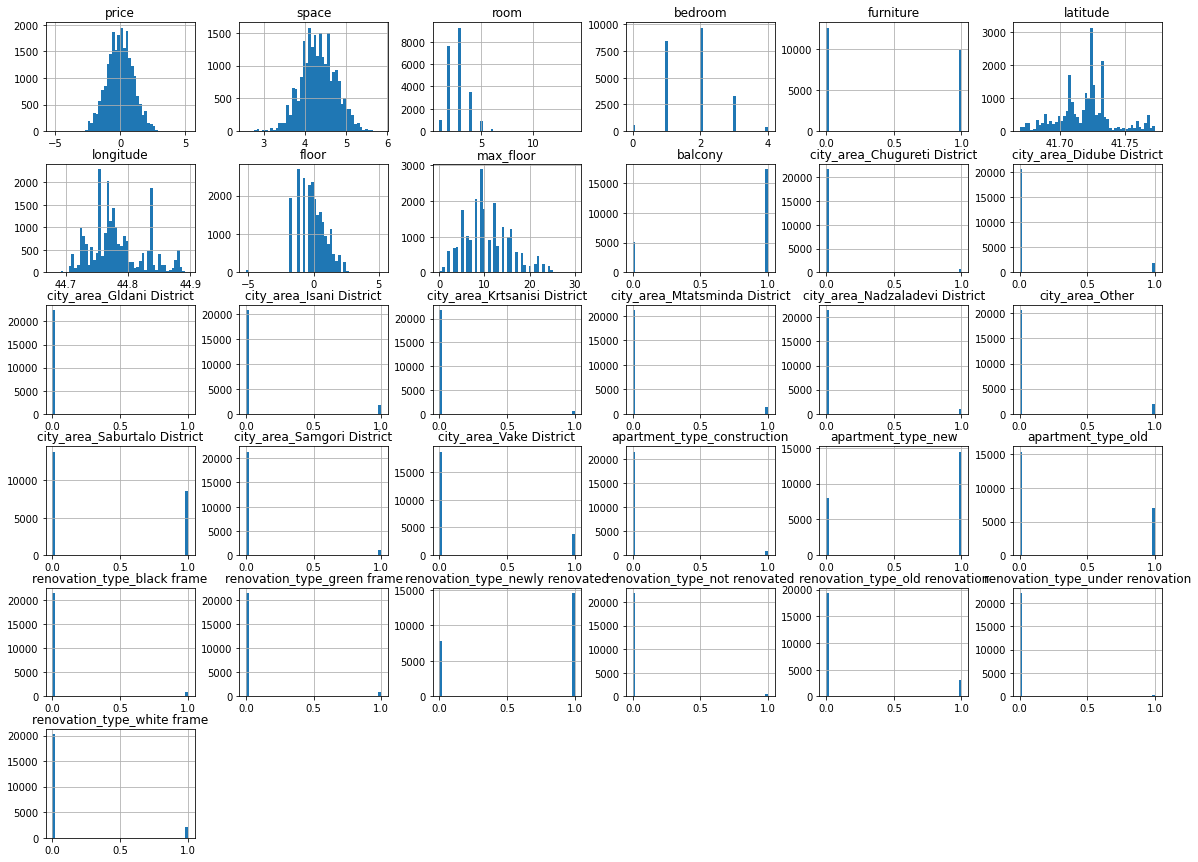

In [101]:
ohe_df.hist(bins=50, figsize=(20,15))
plt.show()

It looks better already - let's see the values of skewness for the variables:

In [102]:
print(f'Floor skew: {ohe_df.floor.skew()}')
print(f'Max_floor skew: {ohe_df.max_floor.skew()}')
print(f'Space skew: {ohe_df.space.skew()}')
print(f'Price skew: {ohe_df.price.skew()}')

Floor skew: -0.16860889870575502
Max_floor skew: 0.5714693992510219
Space skew: -0.030737246865219458
Price skew: 0.022281309301218254


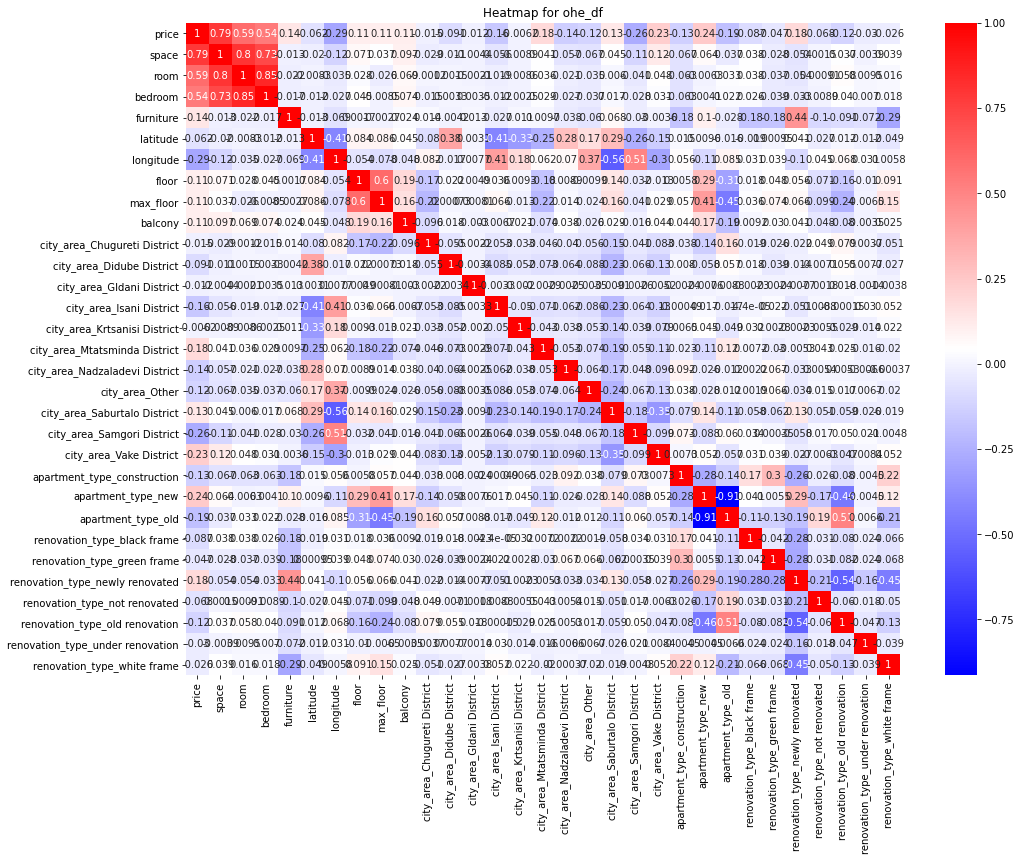

In [103]:
plt.figure(figsize=(16,12))
plt.title('Heatmap for ohe_df')
sns.heatmap(ohe_df.corr(), annot=True, cmap='bwr')
plt.show()

While longitude and latitude were useful for the visualization, I believe that much more insight is found in the district variable, so let's drop them.

In [104]:
X = ohe_df.drop(columns=['price', 'latitude', 'longitude',])
y = ohe_df['price']

Now the train test split and some regressors to be tested:

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [106]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [107]:
y_pred = lin_reg.predict(X_test)


J_mse = mean_squared_error(y_pred, y_test)

R_squared = lin_reg.score(X_test,y_test)
print('MSE:',J_mse)
print('R squared:',R_squared)

MSE: 0.20671958971022122
R squared: 0.7897322631859065


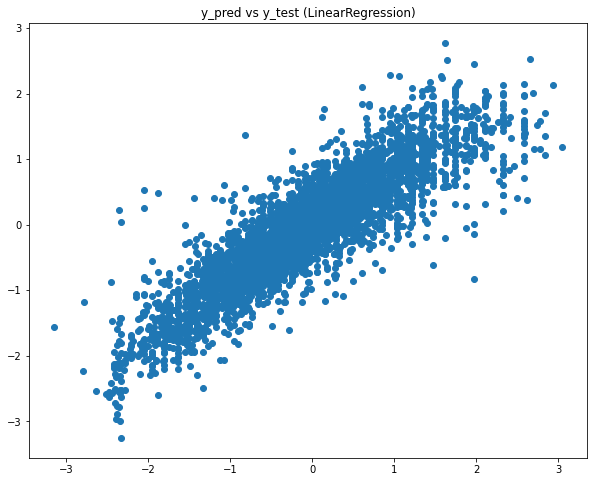

In [108]:
plt.figure(figsize=(10,8))
plt.title('y_pred vs y_test (LinearRegression)')
plt.scatter(y_test, y_pred)
plt.show()

In [109]:
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_train,y_train)

y_pred = lin_reg_2.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

R_squared = lin_reg_2.score(X_test,y_test)
print('MSE:',J_mse)
print('R squared:',R_squared)

MSE: 1641719255230.0122
R squared: -1669897820351.8496


Well polynomial features were a disappointment, let's get back to our previous linear features:

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [111]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train,y_train)
y_pred = tree_reg.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

R_squared = tree_reg.score(X_test,y_test)
print('MSE:',J_mse)
print('R squared:',R_squared)

MSE: 0.2697942344424602
R squared: 0.725575001569858


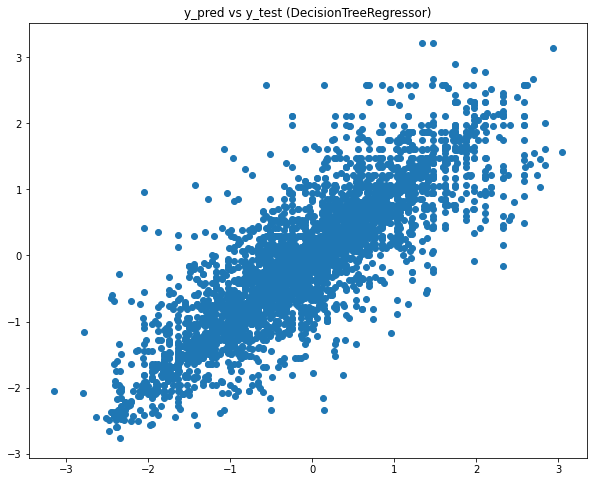

In [112]:
plt.figure(figsize=(10,8))
plt.title('y_pred vs y_test (DecisionTreeRegressor)')
plt.scatter(y_test, y_pred)
plt.show()

In [113]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train,y_train)
y_pred = forest_reg.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

R_squared = forest_reg.score(X_test,y_test)
print('MSE:',J_mse)
print('R squared:',R_squared)

MSE: 0.15787877797048475
R squared: 0.8394113814691497


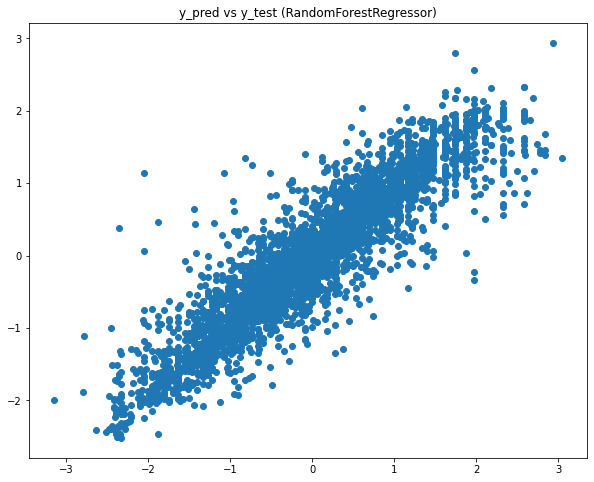

In [114]:
plt.figure(figsize=(10,8))
plt.title('y_pred vs y_test (RandomForestRegressor)')
plt.scatter(y_test, y_pred)
plt.show()

In [115]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train,y_train.values.ravel())
y_pred = gb_reg.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

R_squared = gb_reg.score(X_test,y_test)
print('MSE:',J_mse)
print('R squared:',R_squared)

MSE: 0.1902628991794123
R squared: 0.8064714173135524


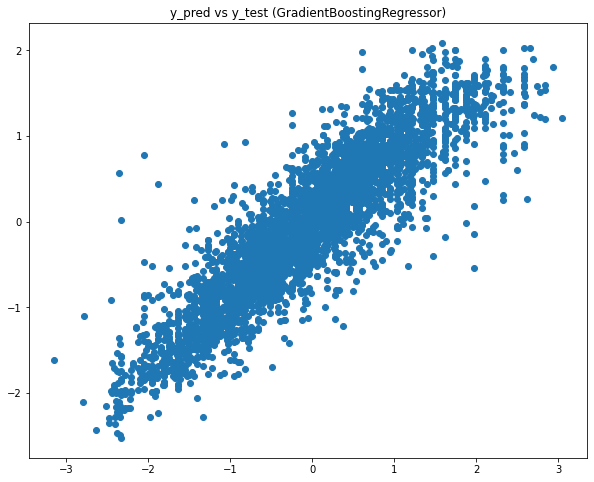

In [116]:
plt.figure(figsize=(10,8))
plt.title('y_pred vs y_test (GradientBoostingRegressor)')
plt.scatter(y_test, y_pred)
plt.show()

In [117]:
ens_model = Pipeline([
    ('reg', GradientBoostingRegressor())
])

ens_search = GridSearchCV(
    ens_model, param_grid={
        'reg__max_depth' : [2,3,4,5,6],
    }
)


ens_search.fit(X_train, y_train.values.ravel())
y_pred = ens_search.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

R_squared = ens_search.score(X_test,y_test)
print('MSE:',J_mse)
print('R squared:',R_squared)

MSE: 0.16789641949008544
R squared: 0.8292217965657835


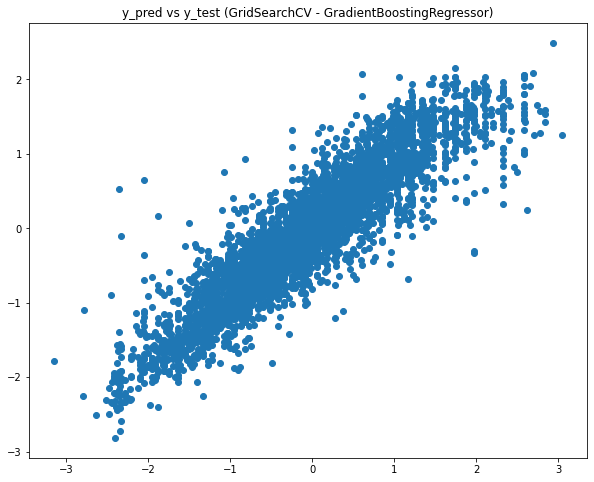

In [118]:
plt.figure(figsize=(10,8))
plt.title('y_pred vs y_test (GridSearchCV - GradientBoostingRegressor)')
plt.scatter(y_test, y_pred)
plt.show()

In [121]:
ens_model_2 = Pipeline([
    ('reg', RandomForestRegressor())
])

ens_search_2 = GridSearchCV(
    ens_model_2, param_grid={
        'reg__n_estimators': [100, 200, 500], 
        'reg__max_depth': [None, 1, 2, 3], 
        'reg__min_samples_split': [2, 3],
    },
    verbose=2,
)


ens_search_2.fit(X_train, y_train)
y_pred = ens_search_2.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

R_squared = ens_search_2.score(X_test,y_test)
print('MSE:',J_mse)
print('R squared:',R_squared)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100, total=   5.5s
[CV] reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV]  reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100, total=   5.6s
[CV] reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100 
[CV]  reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100, total=   5.6s
[CV] reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100 
[CV]  reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100, total=   5.6s
[CV] reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100 
[CV]  reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=100, total=   5.5s
[CV] reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=200 
[CV]  reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=200, total=  11.1s
[CV] reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=200 
[CV]  reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=200, total=  11.1s
[CV] reg__max_depth=None, reg__min_samples_split=2, reg__n_estimators=200 
[CV]  reg_

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 10.4min finished


MSE: 0.1559242739477086
R squared: 0.841399432713056


In [122]:
print(ens_search_2.best_estimator_)

Pipeline(steps=[('reg',
                 RandomForestRegressor(min_samples_split=3, n_estimators=500))])


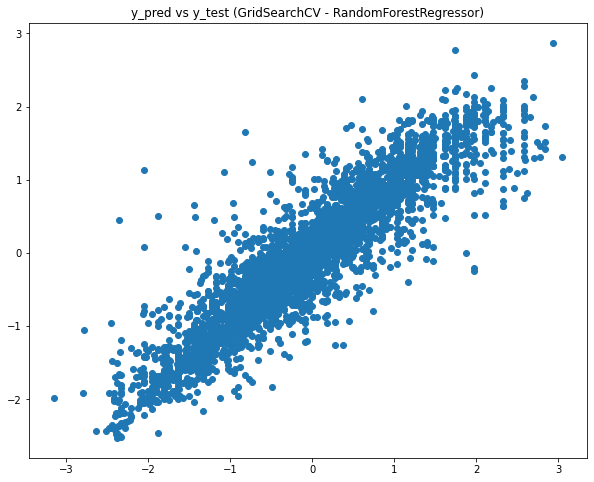

In [123]:
plt.figure(figsize=(10,8))
plt.title('y_pred vs y_test (GridSearchCV - RandomForestRegressor)')
plt.scatter(y_test, y_pred)
plt.show()

# Final thoughts (for now ;))

As you can see, the RandomForestRegressor turned out to be the best out of the tested regressors - even better, when we tuned some hyperparameters via GridSearchCV. These are some initial and in my opinion, quite nice results ;)